In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ctypes
from tqdm import tqdm

  0%|          | 0/8191 [00:00<?, ?it/s]

100%|██████████| 8191/8191 [00:00<00:00, 25143.99it/s]


Exception: Stop here

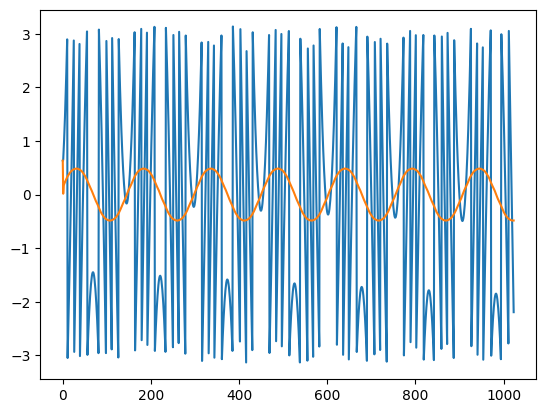

In [2]:
# load baseband data (fm_6300_75k_iq.csv)
ila_data = np.loadtxt('fm_6300_75k_iq.csv', delimiter=',')
# get the last two columns as i q data
i_data = ila_data[:, -2].astype(np.int64) >> 2
q_data = ila_data[:, -1].astype(np.int64) >> 2


atan2_lib = ctypes.CDLL('./atan2.so')
atan2_lib.atan2.argtypes = [ctypes.c_int64, ctypes.c_int64, ctypes.c_int64]
atan2_lib.atan2.restype = ctypes.POINTER(ctypes.c_int64)

unwrap_diff_lib = ctypes.CDLL('./unwrap_diff.so')
unwrap_diff_lib.unwrap_diff.argtypes = [ctypes.c_int64, ctypes.c_int64]
unwrap_diff_lib.unwrap_diff.restype = ctypes.POINTER(ctypes.c_int64)

angle = np.zeros(len(i_data)-1, dtype=np.int64)
angle_unwrap = np.zeros(len(i_data)-1)

for i in tqdm(range(len(i_data)-1)):
    flg = False
    en = 1
    while not flg:
        angle_ptr = atan2_lib.atan2(en, q_data[i], i_data[i])
        unwrapped_ptr = unwrap_diff_lib.unwrap_diff(angle_ptr[0], angle_ptr[1])
        unwrapped_ptr = unwrap_diff_lib.unwrap_diff(0, angle_ptr[1])
        en = 0
        flg = True if angle_ptr[0] != 0 else False
    angle[i] = angle_ptr[1]
    angle_unwrap[i] = unwrapped_ptr[1]

angle = angle / (2**29)
angle_unwrap = angle_unwrap / (2**29)

plt.plot(angle[:1024])
plt.plot(angle_unwrap[:1024])
raise Exception("Stop here")
# get the angle
# angle = np.arctan2(q_data, i_data)
angle = np.unwrap(angle) # unwrap the angle to avoid discontinuities
angle = np.diff(angle) # get the difference between consecutive angles

# plot the angle
plt.figure(figsize=(10, 5))
plt.plot(angle[:1024])
plt.title('Angle of I/Q Data (First 256 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Angle (radians)')

# the fft of the angle
plt.figure(figsize=(10, 5))
angle_fft = np.fft.fft(angle)
angle_fft = np.fft.fftshift(angle_fft) # shift the zero frequency component to the center
angle_freq = np.fft.fftfreq(len(angle), d=1/(960e3))
angle_freq = np.fft.fftshift(angle_freq) # shift the zero frequency component to the center
plt.plot(angle_freq[(angle_freq>0) & (angle_freq < 50e3)], 20*np.log10(np.abs(angle_fft[(angle_freq>0) & (angle_freq < 50e3)])/len(angle)))
plt.title('Magnitude Spectrum of Angle')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xticks(np.arange(0, 50e3+1, 6.3e3))
plt.grid()
plt.show()

In [4]:
np.max(angle_unwrap[3:])

np.float64(0.4845607131719589)

In [19]:
nco_lib = ctypes.CDLL('./nco.so')
nco_lib.nco.argtypes = [ctypes.c_uint64]
nco_lib.nco.restype = ctypes.POINTER(ctypes.c_int64)

idxDec_lib = ctypes.CDLL('./idxDec_i.so')
idxDec_lib.idxDec.argtypes = [ctypes.c_int64]
idxDec_lib.idxDec.restype = ctypes.POINTER(ctypes.c_int64)

lutDec_lib = ctypes.CDLL('./lutDec_i.so')
lutDec_lib.lutDec.argtypes = [ctypes.c_int64, ctypes.c_int64]
lutDec_lib.lutDec.restype = ctypes.POINTER(ctypes.c_int64)

lut_data = np.int64((np.sin(np.linspace(0, 1, 2**12) * np.pi/2)) * (2**17 - 1))

def decode(idx: np.int64):
    idx_ptr = idxDec_lib.idxDec(idx)
    out_ptr = lutDec_lib.lutDec(idx, lut_data[idx_ptr[0]])
    return out_ptr[0]

cic_lib = ctypes.CDLL('./pipe_cic4_d128.so')
cic_lib.pipe_cic4_d128.argtypes = [ctypes.c_int64]
cic_lib.pipe_cic4_d128.restype = ctypes.POINTER(ctypes.c_int64)

cic_comp_lib = ctypes.CDLL('./cic4_d128_comp64.so')
cic_comp_lib.cic4_d128_comp64.argtypes = [ctypes.c_int64, ctypes.c_int64]
cic_comp_lib.cic4_d128_comp64.restype = ctypes.POINTER(ctypes.c_int64)

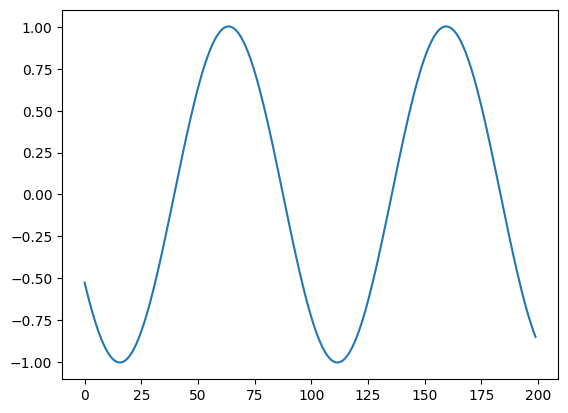

In [23]:
fs = 122.88e6 # Sampling frequency
ts = 1/fs   # Sampling period

lo_freq = 7.68e6
lo_tw = int((lo_freq / fs) * (2**24))

signal_freq = 1e4

signal_length = int(2 * (1/np.abs(signal_freq - lo_freq)) * fs) 
signal_length = signal_length if signal_length > 65536 else 65536
    
signal = np.sin(2 * np.pi * signal_freq * np.arange(signal_length) * ts + 1.7, dtype=np.float64)

signal_int = (signal * (2**15 - 1)).astype(np.int64)

signal_i_filtered = np.zeros_like(signal, dtype=np.int64)
signal_i_valid    = np.zeros_like(signal, dtype=bool)

cic = cic_lib.pipe_cic4_d128
cic_comp = cic_comp_lib.cic4_d128_comp64

for i, sig in enumerate(signal_int):
    cic_ptr = cic(sig)
    cic_out_valid = cic_ptr[0]
    cic_out = cic_ptr[1]

    cic_comp_ptr = cic_comp(cic_out_valid, cic_out)

    signal_i_valid[i] = cic_comp_ptr[0] 
    signal_i_filtered[i] = cic_comp_ptr[1]


signal_i_filtered = signal_i_filtered[signal_i_valid] / (2**34)
signal_i_filtered = signal_i_filtered[64:]

plt.plot(signal_i_filtered[:200])


In [17]:
lo_freq = 1e4
lo_tw = int((lo_freq / fs) * (2**24))

In [4]:
#print in Hexdecimal
print("{:x}, {:x}, {:x}".format(np.int32(np.pi*2**29).astype(np.uint32), np.int64(-1 * np.pi*2**29).astype(np.uint64), np.int64(2 * np.pi*2**29).astype(np.uint64)))

6487ed51, ffffffff9b7812af, c90fdaa2
